In [13]:
import torch
import torchvision
from torch import nn
from torch.nn.functional import relu
from torchvision import transforms, datasets
from torchvision.datasets import VisionDataset
from torch.utils.data import DataLoader
from torchinfo import summary

import nibabel as nib

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import os
from random import choice

In [14]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(DEVICE)

PIN_MEMORY = True if DEVICE == "cuda" else False
DEVICE, PIN_MEMORY

('cpu', False)

In [1]:
# Here we set all the hyper parameters

NUM_CHANNELS = 1
NUM_CLASSES = 1
NUM_LEVELS = 3

LR = 0.0001
NUM_EPOCHS = 10
BATCH_SIZE = 4
NUM_WORKERS = 0

INPUT_IMAGE_HEIGHT = 572
INPUT_IMAGE_WIDTH = 572

THRESHOLD = 0.5

BASE_OUTPUT = "output"

mask_dir= "C:/Users/HP/Desktop/2024 projects/LiTS/data/segmentations"

root_dir = "C:/Users/HP/Desktop/2024 projects/LiTS/data"
scan_dir1 = "C:/Users/HP/Desktop/2024 projects/LiTS/data/volume_pt1"
scan_dir2 = "C:/Users/HP/Desktop/2024 projects/LiTS/data/volume_pt2"
scan_dir3 = "C:/Users/HP/Desktop/2024 projects/LiTS/data/volume_pt3"
scan_dir4 = "C:/Users/HP/Desktop/2024 projects/LiTS/data/volume_pt4"
scan_dir5 = "C:/Users/HP/Desktop/2024 projects/LiTS/data/volume_pt5"
scan_dirs = [scan_dir1, scan_dir2, scan_dir3, scan_dir4, scan_dir5]
len(scan_dirs)

5

In [16]:
walk_list= []
mask_walk= []
data_dir_list= []
mask_dir_list = []
"""
for item in os.walk(scan_dir1):
    walk_list.append(item)

"""
for dir in scan_dirs:
    for file_name in os.walk(dir):
        walk_list.append(file_name)

for file_name in os.walk(mask_dir):
    mask_walk.append(file_name)

for i in range(len(mask_walk[0][2])):
    mask_dir_list.append(mask_dir + "/" + str(mask_walk[0][2][i]))

for i in range(51):
    if i <= 10:
        data_dir_list.append(root_dir + "/volume_pt1/" +str(walk_list[0][2][i]))
    elif i > 10 and i <= 20:
        data_dir_list.append(root_dir + "/volume_pt2/" + str(walk_list[1][2][10-i]))
    elif i > 20 and i <= 30:
        data_dir_list.append(root_dir + "/volume_pt3/" + str(walk_list[2][2][20-i]))
    elif i > 30 and i <= 40:
        data_dir_list.append(root_dir + "/volume_pt4/" + str(walk_list[3][2][30-i]))
    elif i > 40 and i <= 50:
        data_dir_list.append(root_dir + "/volume_pt5/" + str(walk_list[4][2][40-i]))

train_set, test_set = torch.utils.data.random_split(data_dir_list, [0.8, 0.2])
train_mask, test_mask = torch.utils.data.random_split(mask_dir_list, [0.8, 0.2])

In [17]:
# Creating the custom segmentation dataset class    
class SegmentationDataset(VisionDataset):
    """
    It is imprtant to note that though the images must be converted to float. 
    We should also note that this conversion changes the image to a reasonable extent.
    Hence understanding precision and how it affects this dataset may be valuable, 
    But, this is an existing limitation to computers and I am not sure we can do anything about it.
    """
    def __init__(self, imagePaths, maskPaths, transforms=None):
        super().__init__()
        
        self.imagePaths = imagePaths
        self.maskPaths = imagePaths
        self.transforms = transforms

    def __len__(self):
        return len(self.imagePaths)

    def __getitem__(self, idx):
        imagePath = self.imagePaths[idx]
        maskPath = self.maskPaths[idx]

        imag = nib.load(imagePath).dataobj[:, :, 59]
        conv = imag.astype(np.float32)
        converted = np.stack([conv] * 3, axis=0)
        conver = (torch.from_numpy(converted)).permute(0, 1,2)
        mask = nib.load(maskPath).dataobj[:,:, 59]
        con = mask.astype(np.float32)
        convert = np.stack([con] * 3, axis=0)
        conve = (torch.from_numpy(convert)).permute(0,1,2)
        
        # data = torch.Tensor(int32)
        # loaded_data.append(data)

        if self.transforms is not None:
            image = self.transforms(conver)
            mask = self.transforms(conve)
        else:
            image = conver
            image = conve

        return (image, mask)



In [18]:
import torchvision.transforms.functional as TF
transform = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.Resize((INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH)),
                                transforms.ToTensor()
                                ])

train_dataset = SegmentationDataset(imagePaths = train_set, maskPaths= train_mask, transforms = transform)

test_dataset = SegmentationDataset(imagePaths = test_set, maskPaths = test_mask, transforms = transform)

In [19]:

train_dataloader = DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle= True,
    num_workers= NUM_WORKERS,
    pin_memory= PIN_MEMORY,
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size= BATCH_SIZE,
    shuffle= False,
    num_workers= NUM_WORKERS,
    pin_memory = PIN_MEMORY,
)

len(train_dataloader), len(test_dataloader)

(11, 3)

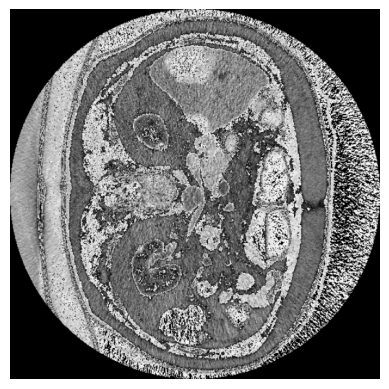

In [21]:

image_batch = next(iter(train_dataloader))
image = image_batch[0][2]
plt.imshow(image.permute(1,2,0))
plt.axis(False);

SyntaxError: invalid syntax (1902577783.py, line 1)